Fitting Polynomials
===================

In this exercise, we are going to explore the bias–variance tradeoff
on a illustrative problem, polynomial fitting.

We are now going to use the following model, which can be seen as linear model with enlarged feature space:

$$ 
f(x; \vec\theta) = \sum_{k=0}^{K-1} \theta_k f_k(x) = \theta_0 + \theta_1 x + \ldots \theta_{K-1} x^{K-1},
$$

i.e., one has $f_k(x) = x^k$.  (Note that we are indexing slightly
differently than in the lecture because numpy indices start at zero.)

Write `f_k`, which implements $f_k(x)$, and also a function `fmodel`, which implements $f(x; \vec\theta)$ above

In [3]:
import numpy as np
from copy import copy
import matplotlib.pyplot as pl

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5zkfwkua because the default path (/home/e00473828/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
def f_k(k, x):
    return np.power(x, k)
    
def fmodel(x, theta):
    return sum([the * f_k(k, x) for k, the in enumerate(theta)])

In [5]:
np.testing.assert_allclose(f_k(0, 3.0), 1.0, atol=1e-6)
np.testing.assert_allclose(f_k(1, 2.5), 2.5, atol=1e-6)
np.testing.assert_allclose(f_k(2, 4.0), 16.0, atol=1e-6)

np.testing.assert_allclose(fmodel(3.0, np.array([.4])), 0.4, atol=1e-6)
np.testing.assert_allclose(fmodel(1.0, np.array([.7, 0.5])), 1.2, atol=1e-6)
np.testing.assert_allclose(fmodel(1.0, np.array([.7, 0.5])), 1.2, atol=1e-6)


Load and randomize data set
-------------------------------------
Instead of needing to randomly select the data by throwing dice,
a simpler technique is to just randomize the observations.  Afterwards,
we can simply select the first $n$ rows and be sure we are not biasing
our calculations.

 1. Use numpy's `loadtxt` function to again load a data matrix, where
    each row corresponds to an observation with $x$ and $y$ value,
    from the file `poly.txt`.
  
 2. Randomly permute the rows in the data matrix (Hint: look
    through the methods for `random`)
 
 3. Again split up the result into a `x` and `y` vector.

In [6]:
random = np.random.default_rng(777)

In [7]:
data = np.loadtxt("poly.txt")

# just for non randomized plot
x_notrandom = copy(data[:, 0])
y_notrandom = copy(data[:, 1])

# set seed for reproducibility
# (particularly important so that graph explanations match the graphs)
np.random.seed(8942)
np.random.shuffle(data)
x = data[:, 0]
y = data[:, 1]





In [8]:
print(x[:5])
print(y[:5])

[-0.2215603  1.152651  -0.6680238  1.631392  -0.6644771]
[-0.8863897  2.258163   3.689974   3.381769   1.869168 ]


In [9]:
assert (x, y) is not None

# Check if permutation did not mess up stuff
_sorted = np.sort(np.rec.fromarrays([x,y], names='x,y'))
np.testing.assert_allclose(_sorted.x, np.loadtxt('poly.txt')[:,0], atol=1e-6)
np.testing.assert_allclose(_sorted.y, np.loadtxt('poly.txt')[:,1], atol=1e-6)

# Check for randomness...
sortedx = (x[1:] > x[:-1]).sum()
assert sortedx > .3 * x.size and sortedx < .7 * x.size

Let's check if we did a good job on randomizing the data.
There is a cute way of doing this:

We again do a scatter plot (`pl.scatter`), where I plot `y`
over `x`.  These plots allow you to use **color** to attach
information to each data point.
We want color to represent the position of the observation
within the array, so we simply pass a vector with indices.
If you like, you can play around with the [`cmap` argument].

If the resulting plot looks a little bit like an impressionist
painting, which the colors nicely scattered, then you did a
good job randomizing.  If you can spot a visible gradient, then
it means that position and index are correlated, and something
went wrong in the randomization.

[`cmap` argument]: https://matplotlib.org/stable/tutorials/colors/colormaps.html

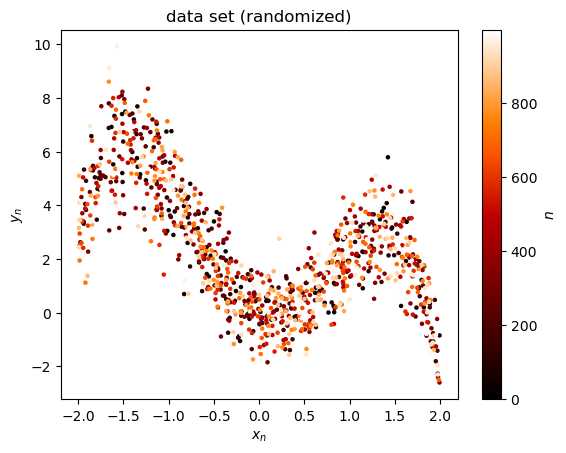

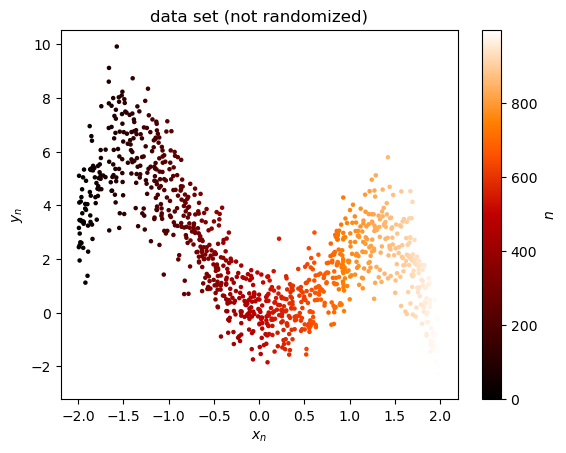

In [10]:
pl.scatter(x, y, c=np.arange(1000), s=5,cmap="gist_heat")
pl.xlabel('$x_n$')
pl.ylabel('$y_n$')
pl.title('data set (randomized)')
pl.colorbar(label='$n$')
pl.show()

pl.scatter(x_notrandom, y_notrandom, c=np.arange(1000), s=5,cmap="gist_heat")
pl.xlabel('$x_n$')
pl.ylabel('$y_n$')
pl.title('data set (not randomized)')
pl.colorbar(label='$n$')
pl.show()

Above we can clearly see the difference between the randomized and non randomized data sets. So this method of checking if the data was thoroughly mixed works well. At least it holds up to visual inspection.

Linear model with enlarged feature space
------------------------------
Let's fix the maximum polynomial order at `Kmax=20`.

Now you should construct an augmented "design matrix" `Xtilde` with `N=1000`
rows, corresponding to the observations, and `Kmax=20` columns with the
element $X_{kn} = \tilde x_{n,k} = f_k(x_n)$, i.e., the $k$-th feature of the
$n$-th observation.

In [11]:
Kmax = 20
Xtilde = np.array([[f_k(k, xi) for k in range(Kmax)] for xi in x])

In [12]:
Xtilde[:4, :4]

array([[ 1.        , -0.2215603 ,  0.04908897, -0.01087617],
       [ 1.        ,  1.152651  ,  1.32860433,  1.53141711],
       [ 1.        , -0.6680238 ,  0.4462558 , -0.29810949],
       [ 1.        ,  1.631392  ,  2.66143986,  4.34185169]])

In [13]:
assert (Xtilde,) is not None
assert Xtilde.shape == (1000, 20)

_rowsums = [
    1.00000000e+03,  2.74192173e+01,  1.26907921e+03,  6.80383109e+01,
    3.03906894e+03,  1.55539066e+02,  8.77137073e+03,  3.07412343e+02,
    2.76456589e+04,  3.21997393e+02,  9.16437544e+04, -1.40425556e+03,
    3.13851105e+05, -1.36666460e+04,  1.09962081e+06, -7.87415634e+04,
    3.91828369e+06, -3.86712415e+05,  1.41452574e+07, -1.75920784e+06]
np.testing.assert_allclose(Xtilde[:,:].sum(0), _rowsums, atol=1e-3)

Write the corresponding model function `fmodel_lin` which maps elements `xtilde` ($\tilde x_n$)
to the predicted $y$ (note that this is now a linear model!), given the
model parameters `theta`:
$$
    \hat y_n = f_\mathrm{lin}(\tilde x_n; \vec\theta)
$$

Also implement the cost function, and include a Ridge regularization term,
weighted with `lambda_`:
$$
    \operatorname{cost}(\tilde X, \vec y; \vec\theta, \lambda) 
    = \frac 1N \sum_{n=1}^N | y_n - f_\mathrm{lin}(\tilde x_n; \vec\theta) |^2 + \mbox{(Ridge regularization term)}
$$
You should not use hardcoded values for $N$ or $K$ since we will change them later - infer them from the size of the arguments instead.

**Also note** the additional factor $1/N$ in the first term compared to the lecture (the regularization term is not scaled).

In [14]:
def fmodel_lin(xtilde, theta):
    # Here is a check for your convenience
    if np.ndim(xtilde) != 1 or np.shape(xtilde) != np.shape(theta):
        raise ValueError("xtilde and theta must be vectors of equal size")
    return xtilde.T @ theta
    
def cost(Xtilde, y, theta, lambda_=0):
    N = len(y)
    standard_cost = 1 / N * sum([(yi - fmodel_lin(Xtilde[i, :], theta)) ** 2 for i, yi in enumerate(y)])
    regularization = (lambda_ ** 2) * (theta@theta)
    return standard_cost + regularization

In [15]:
_theta_dummy = np.exp(-np.arange(20))
np.testing.assert_allclose(fmodel_lin(np.ones(20), _theta_dummy), _theta_dummy.sum())

np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy), 8.0888421161, atol=1e-6)
np.testing.assert_allclose(cost(Xtilde[:,:10], y, _theta_dummy[:10]), 8.0573235038, atol=1e-6)

np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy, 1.0), 9.24536, atol=1e-6)
np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy, 10.0), 123.740606, atol=1e-6)

In [16]:
cost(Xtilde, y, _theta_dummy, 0.1)

8.10040729253129

We need one final function: one which minimizes the `cost` function for given $\tilde X$, $y$
and $\lambda$ and returns the optimal parameters $\theta^*$:
$$
    \theta^* = \arg\min_\theta \operatorname{cost}(\tilde X, \vec y; \vec\theta, \lambda)
$$
Use the regularized normal equations to solve.

**Careful**: the cost function above contains the scaling factor $1/N$ with respect to the lecture. You can include this in the equations presented in the lecture by instead scaling your $\lambda$ by a factor $\sqrt N$ in the solution formulas of the lecture, since for the minimization only the balance between regularization term and cost term matters.

In [17]:
def ridge_regression(Xtilde, y, lambda_=0):
    N, K = np.shape(Xtilde) 
    return np.linalg.inv(Xtilde.T @ Xtilde + N * lambda_**2 * np.eye(K)) @ Xtilde.T @ y

In [18]:
ridge_regression(Xtilde, y)

array([ 4.29523367e-02, -8.40686520e-01,  3.87034469e+00, -6.91178620e+00,
        1.56514549e+00,  2.71862508e+01, -3.80945400e+00, -5.12758830e+01,
        1.81201406e+00,  5.50406822e+01,  3.96112746e-01, -3.55005334e+01,
       -7.28106812e-01,  1.39348092e+01,  2.91165851e-01, -3.25065236e+00,
       -5.12809400e-02,  4.13735188e-01,  3.45974538e-03, -2.21136535e-02])

In [19]:
assert ridge_regression(Xtilde, y).shape == (20,)

# Use reduced set here because of numerical instability otherwise
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.0), 
                           [ 1.47642395, -1.16072359,  0.69449246], atol=1e-5)
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.01),
                           [ 1.4761718 , -1.160631  ,  0.69457283], atol=1e-5)
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.1), 
                           [ 1.45179605, -1.15153417,  0.70226027], atol=1e-5)

Polynomial fit
--------------------

With all those functions we are finally ready to tackle polynomial fitting.

Again split your data, `Xtilde` and `y`, into two sets, where you should put half
into the training set (`Xtilde_train`, `y_train`) and half into the validation set
(`Xtilde_test`, `y_test`).  In total, there should be `N` observations, where
`N` can be smaller than the total number of points we have in our set.

Since we have previously randomized the data, this simplifies our job: say, N=100,
then we simply put the first 50 observations in the training set and the next 50
observations into the validation set.

We want to study how the fit changes as we increase or reduce the polynomial order.
To do so, truncate the design matrices to the first `K` features (thereby enforcing
fitting with a polynomial of order `K-1`).

**Note**: numpy may get confused if you use floating point numbers as indices. You
can pass a number through the `int()` function to truncate the fractional part.

In [20]:
K = 10
N = 100

In [21]:
Xtilde_train, Xtilde_test = Xtilde[:N//2,:K], Xtilde[N//2:N, :K]
y_train, y_test = y[:N//2], y[N//2:N]

In [22]:
y_train

array([-8.863897e-01,  2.258163e+00,  3.689974e+00,  3.381769e+00,
        1.869168e+00,  5.789810e+00,  2.525988e-01,  2.273177e+00,
        3.661882e+00,  5.157042e+00,  2.121335e+00,  3.397693e+00,
        1.303977e-02,  1.216960e+00, -2.696271e-01,  6.750147e+00,
       -2.353678e-01,  3.046734e+00, -1.610474e-01, -2.944857e-02,
        7.332155e+00,  1.726455e-01,  1.126724e-04,  7.201034e+00,
        3.902965e+00,  4.328162e-01,  7.494681e+00,  6.921284e+00,
        5.759851e+00,  2.597451e+00,  7.402454e+00,  9.129870e-01,
        2.727481e+00,  3.745943e+00,  9.276554e-01,  4.692200e-01,
        7.687584e+00,  3.817529e+00,  1.845843e-01,  2.282402e+00,
        1.999135e+00,  3.022186e+00, -8.513430e-01,  6.578890e+00,
        3.768187e+00,  1.210396e+00,  3.769710e+00,  3.193593e-01,
        2.463012e-01,  5.201350e+00])

In [23]:
assert (Xtilde_train, Xtilde_test, y_train, y_test) is not None
assert Xtilde_train.shape == (N//2, K)
assert Xtilde_test.shape == (N//2, K)
assert y_train.shape == (N//2,)
assert y_test.shape == (N//2,)

Perform Ridge regression on the training set for `lambda_=0` for now, and plot the fitted
curve as well as the points in the validation set (see previous assignment).

Hint: to plot the $x$ values, you can observe that they are still present in one of the
columns of `Xtilde`.

Don't forget labels and a legend!

In [24]:
lambda_ = 0

Text(0.5, 1.0, 'Ridge regression with N = 100')

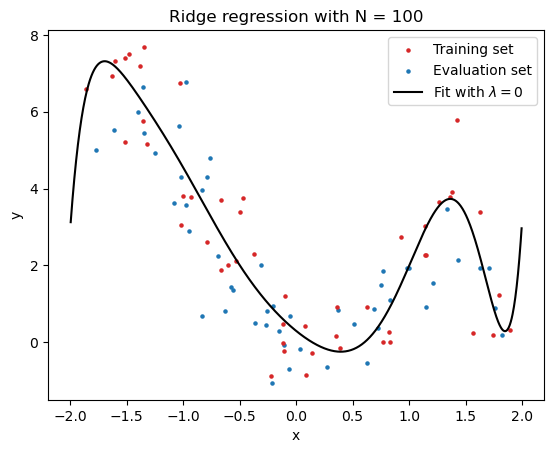

In [38]:
# do regression
theta_star = ridge_regression(Xtilde_train, y_train, lambda_)

# plot dataset
pl.scatter(Xtilde_train[:,1:2],y_train, color="C3", s=5, zorder=-100, label="Training set")
pl.scatter(Xtilde_test[:,1:2],y_test, color="C0", s=5, zorder=-101, label="Evaluation set")

# plot prediction
xplot = np.linspace(min(x), max(x), 1000)
pl.plot(xplot, fmodel(xplot, theta_star), color="k", label=f"Fit with $\lambda = {lambda_}$")

# make plot nicer
pl.legend()
pl.ylabel("y")
pl.xlabel("x")
pl.title(f"Ridge regression with N = {N}")

Also compute the in error and out error and print it

In [39]:
E_in = cost(Xtilde_train, y_train, theta_star, lambda_)
E_out = cost(Xtilde_test, y_test, theta_star, lambda_)

print("    in-sample error: %.5g" % E_in)
print("out-of-sample error: %.5g" % E_out)

    in-sample error: 0.99629
out-of-sample error: 1.2168


Execute the cells from "Polynomial fit" downwards again while varying
parameters:

 (1) while fixing `N=100`, vary the polynomial order `K`
 
 (2) while fixing `K=20`, vary the number of data points
 
 (3) take a case high `K` and low `N` and vary `lambda_`
 
What do you observe for in- and out-error in those cases, and why?

### (1) Varying K

In [61]:
def compareFits(K_list, N_list, lambda_list, title):
    for K, N, lambda_ in zip(K_list, N_list, lambda_list):
        Xtilde_train, Xtilde_test = Xtilde[:N//2,:K], Xtilde[N//2:N, :K]
        y_train, y_test = y[:N//2], y[N//2:N]
        theta_star = ridge_regression(Xtilde_train, y_train, lambda_)
        
        E_in = cost(Xtilde_train, y_train, theta_star, lambda_)
        E_out = cost(Xtilde_test, y_test, theta_star, lambda_)
        
        # plot prediction
        xplot = np.linspace(min(x), max(x), 1000)
        pl.plot(xplot, fmodel(xplot, theta_star), label=f"K={K}, N={N}, $\lambda = {lambda_}$, $Ein= {E_in:.2f}$, $Eout= {E_out:.2f}$")

    # plot dataset
    pl.scatter(x, y, color="gray", s=2, zorder=-100)
    
    # make plot nicer
    pl.legend(loc="upper right")
    pl.ylabel("y")
    pl.ylim(-5.5, 11)
    pl.xlabel("x")
    pl.title(title)

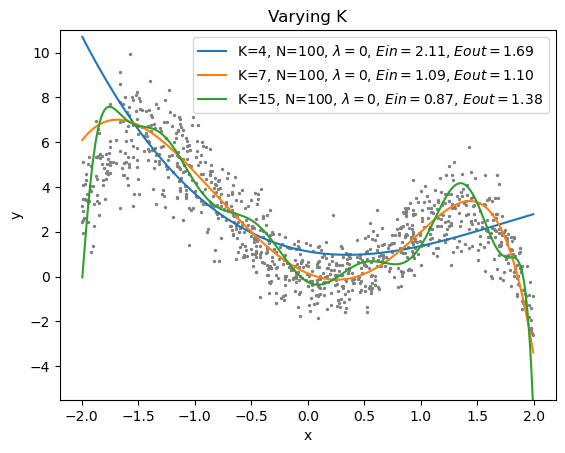

In [62]:
compareFits(K_list=[4, 7, 15], N_list=[100, 100, 100], lambda_list=[0, 0, 0], title="Varying K")

We see that as we increase the parameters $E_{IN}$ keeps getting smaller because the model becomes more powerful and describe the test set in more detail. However we see that $E_{OUT}$ has a minimum somewhere in the range, At this point we change from under-fitting to over-fitting the data. Visually it is quite clear that the underfit plot simply isn't a polynomial of high enough degree to properly fit the data. And we also clearly see that the high degree polynomial gives too much weight to high frequency feautures present in the training data.

### (2) Varying N

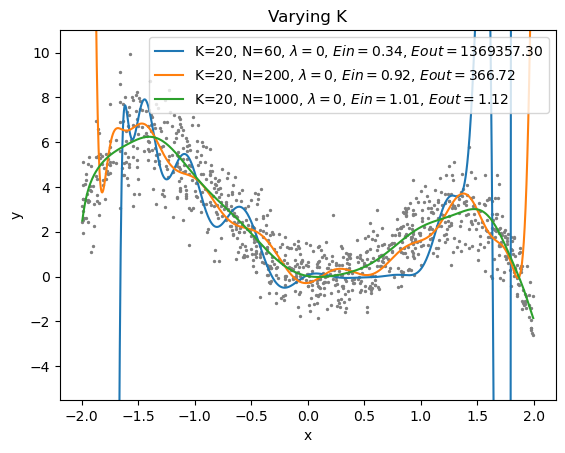

In [63]:
compareFits(K_list=[20, 20, 20], N_list=[60, 200, 1000], lambda_list=[0, 0, 0], title="Varying K")

For the $N=60$ we see the same issue we as with the overfitting in the previous graph. We are using a polynomial of very high degree to describe a fairly small training set and thus all the high frequency feautures in the training set are accounted for making the model very bad at describing the validation set. As we increase $N$ the extent of the issue lessens because relative to the increasing dataset the model becomes less powerful and the higher frequency feautures will be _averaged out_ more. Nevertheless we still end up overfitting with $K=20$ even if we use all datapoints. $E_{OUT}$

### (2) Varying $\lambda$

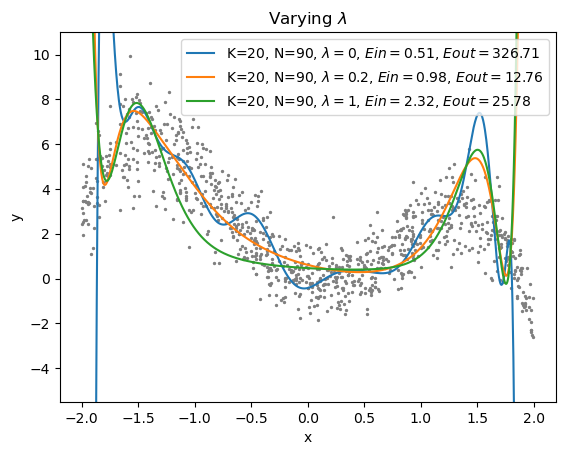

In [46]:
compareFits(K_list=[20, 20, 20], N_list=[90, 90, 90], lambda_list=[0, 0.2, 1], title=f"Varying $\lambda$")

If we use a lot of parameters and very few datapoints we will surely overfit the training set as we can see clearly in the blue plot on the above graph. However increasing the regularization parameter $\lambda$ punishes large coefficients of higher order terms in the polynomial. This has the effect of smoothing  out the fit and thus mitigates the issue of the model fitting the high frequency feautures in the test data too much. Again we see that as we increase $\lambda$ a minimum in $E_{OUT}$ is reached at the point where we smoothed away the high frequency feautures, but didnt yet also smooth away the actual information in the data. $E_{IN}$ obviously reduces as we increase $\lambda$ as $E_{IN}$ represents the particular models best possible description of the training data when $\lambda = 0$.

Analyze behaviour of Ein and Eout
--------------------------------------

Now pack the code you wrote above into a single function, which takes `Xtilde` and `y`
as well as `K`, `N`, and `lambda_` as inputs and returns the a
list of two elements: `E_in` and `E_out`.

In [31]:
def performance(Xtilde, y, K, N, lambda_):
    
    Xtilde_train, Xtilde_test = Xtilde[:N//2,:K], Xtilde[N//2:N, :K]
    y_train, y_test = y[:N//2], y[N//2:N]
    
    theta_star = ridge_regression(Xtilde_train, y_train, lambda_)
    
    E_in = cost(Xtilde_train, y_train, theta_star, lambda_)
    E_out = cost(Xtilde_test, y_test, theta_star, lambda_)
    
    return (E_in, E_out)

In [32]:
performance(Xtilde, y, 10, 100, 0.0)

(0.9962903574611045, 1.2168241795615895)

In [33]:
assert len(performance(Xtilde, y, 10, 100, 0.1)) == 2

np.testing.assert_allclose(
    performance(Xtilde, y, 10, 1000, 0.1), [1.129271, 1.218699], rtol=2e-1)

I will now plot the fitting peformance over the number of features
and the number of observations, respectively.

Explain these graphs below

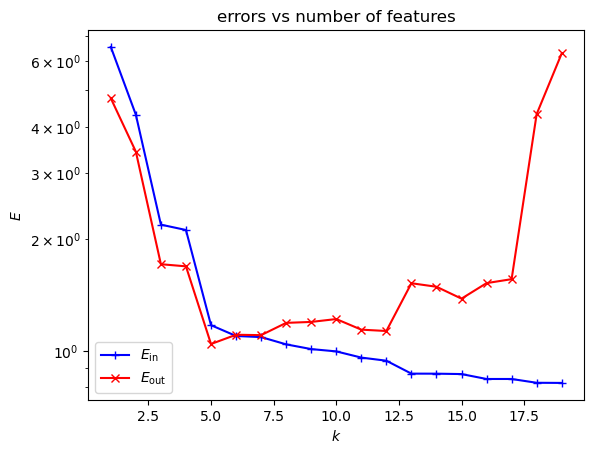

In [34]:
k = np.arange(1,20)
E_in, E_out = np.transpose(
    [performance(Xtilde, y, ki, 100, 0.0) for ki in k])

pl.plot(k, E_in, '-+b', label=r'$E_\mathrm{in}$')
pl.plot(k, E_out, '-xr', label=r'$E_\mathrm{out}$')
pl.title('errors vs number of features')
pl.xlabel('$k$')
pl.ylabel('$E$')
pl.yscale('log')
pl.legend()

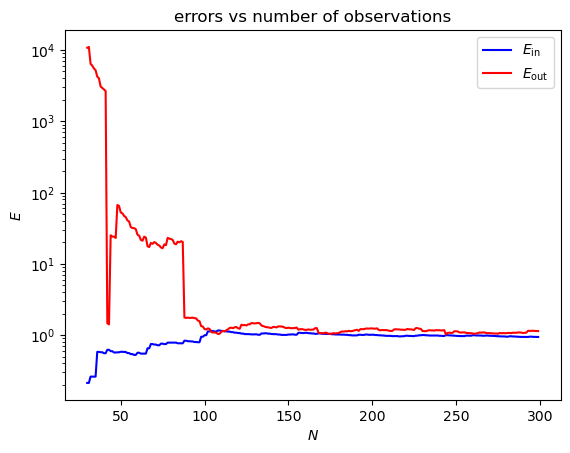

In [35]:
n = np.arange(30,300)
E_in, E_out = np.transpose(
    [performance(Xtilde, y, 10, ni, 0.0) for ni in n])

pl.plot(n, E_in, '-b', label=r'$E_\mathrm{in}$')
pl.plot(n, E_out, '-r', label=r'$E_\mathrm{out}$')
pl.title('errors vs number of observations')
pl.xlabel('$N$')
pl.ylabel('$E$')
pl.yscale('log')
pl.legend()

The **E** vs **K** graph shows that as we increase the number of parameters we initially get improvement in both the IN and OUT errors, however above $K=7$ the OUT error gets worse while the IN error keeps improving. This is because if we use $K>7$ we start to over-fit the training data and thus are also fitting all the _high frequency_ random errors present in the data, which means the model will become worse a describing the general case and thus the OUT error gets worse.

The second plot shows that as we increase the datapoits the IN and OUT errors converge towards each other and towards and Error value known as the bias. After about $N=150$ we see little to no real change in either $E_{IN}$ or $E_{OUT}$ and thus it will not be useful to increase the numberof datapoints even further since this will just needlessly increase the computation time. As N increases we see that the IN error gets worse. This is because as we add more data points our model which is limited in parameters will not be powerful enough to describe all the tiny random jitters in the data, making it worse (up to the bias). The OUT error on the other hand improves since as we increase N the training set becomes more representative of the entire dataset and thus the variance reduces.

Just for fun the cellbelow shows the fit if we choose idealvalues for $N$ adn $K$ based on the two previous graphs

In [36]:

    
compareFits([15, 7, 4], [100, 100, 100], [0, 0, 0])

TypeError: compareFits() missing 1 required positional argument: 'title'